In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from pyBedGraph import BedGraph
from pybedtools import BedTool
import scipy.stats
from scipy.stats import gaussian_kde as kde
from matplotlib.colors import Normalize
from matplotlib import cm
from collections import Counter
import networkx as nx

In [2]:
def modLog(num, denom):
    if num==0 or denom==0:
        return 0
    else:
        return float(format(np.log2(num/denom), '.4f'))

def ShannonEnt(probList):
    """Compute entropy for a list of probabilities."""
    if sum(probList)!=1:  ## input is count or frequency instead of probability
        probList = [i/sum(probList) for i in probList]
    entropy = sum([x*modLog(1,x) for x in probList])
    return float(format(entropy, '.6f'))

def normShannonEnt(probList):
    """Compute normalized entropy for a list of probabilities."""
    if sum(probList) != 1:   ## input is count or frequency instead of probability
        probList = [i/sum(probList) for i in probList]
    entropy = sum([x*modLog(1,x) for x in probList])/np.log2(len(probList))
    if len(probList) == 1:
        entropy = 0
    return float(format(entropy, '.6f'))

In [3]:
def read_regionfile(directory, file_name):
    with open(directory + file_name) as f:
        gems = {}
        for line in f:
            tmp = line.strip().split("\t")
            gemid = tmp[4]
            if gemid in gems.keys():
                gems[gemid].append(tmp[5:])
            else:
                gems[gemid] = [tmp[5:]]
    return gems # all fragments within a complex w/ same GEM ID

In [4]:
def read_raidfile(directory, file_name):
    with open(directory + file_name) as f:
        raids = {}
        for line in f:
            tmp = line.strip().split("\t")
            tmp[1] = int(tmp[1])
            tmp[2] = int(tmp[2])
            raids[tmp[3]] = tmp[0:3]
    return raids

In [5]:
def read_elementsfile(directory, file_name):
    with open(directory + file_name) as f:
        elements = {}
        ebyraid = {}
        for line in f:
            tmp = line.strip().split("\t")
            eid = tmp[5]
            raidid = tmp[17]
            tmp[1] = int(tmp[1])
            tmp[2] = int(tmp[2])
            if tmp[4] != ".":
                tmp.append(tmp[4]) # super-enhancer
                tmp.append('SE')
            else:
                if tmp[12] != '.' and float(tmp[13])>1: # active promoter
                    tmp.append(tmp[12]) # add gene name
                    tmp.append('P')
                else:
                    tmp.append('E')
                    tmp.append('E')
            if eid in elements.keys():
                elements[eid].append(tmp)
            else:
                elements[eid] = tmp
            if raidid in ebyraid.keys():
                ebyraid[raidid].append(eid)
            else:
                ebyraid[raidid] = [eid]
        sebyraid = dict([(key, list(dict.fromkeys([elements[x][4] for x in val if elements[x][4]!="."]))) for key, val in ebyraid.items()])
    elements_se = {}
    for k,v in elements.items():
        if v[3] != ".":
            if v[4] in elements_se.keys():
                elements_se[v[4]].append(v[5])
            else:
                elements_se[v[4]] = [v[5]]
    return elements, ebyraid, sebyraid, elements_se

In [6]:
def read_loopfile(directory, file_name):
    with open(directory + file_name) as f:
        loops = {}
        for line in f:
            tmp = line.strip().split("\t")
            lid = tmp[10]
            rid = tmp[16]
            petcnt = int(tmp[6])
            lpair = lid+","+rid
            if lpair in loops.keys():
                loops[lpair] += petcnt
            else:
                loops[lpair] = petcnt
    return loops

In [7]:
def get_lpbyse(loops, elements):
    lpby1se = {}
    lpby2se = {}
    for key, val in loops.items():
        lanc = key.split(",")[0]
        lse = elements[lanc][4]
        lgene = elements[lanc][12]
        ltpm = elements[lanc][13]
        ranc = key.split(",")[1]
        rse = elements[ranc][4]
        rgene = elements[ranc][12]
        rtpm = elements[ranc][13]
        dist = elements[ranc][1]-elements[lanc][2]
        list2add = [lanc, lse, lgene, ltpm, ranc, rse, rgene, rtpm, val, dist]
        if lse=='.' and rse != ".": # only 1 se; Right anchor overlaps SE
            if rse in lpby1se.keys(): 
                lpby1se[rse].append(list2add)
            else:
                lpby1se[rse] = [list2add]
        if lse!='.' and rse==".": # only 1 se; Left anchor overlaps SE
            if lse in lpby1se.keys(): 
                lpby1se[lse].append(list2add)
            else:
                lpby1se[lse] = [list2add]
        if lse!='.' and rse!='.' and lse != rse: # 2 se
            concat = lse+';'+rse
            if concat in lpby2se.keys(): 
                lpby2se[concat].append(list2add)
            else:
                lpby2se[concat] = [list2add]
    return lpby1se, lpby2se

In [8]:
def plot_boxplot(dataset, dlabel, clr, tit, ylab, fig_name):
    fig = plt.figure(figsize = (8,6))
    medianprops = dict(linewidth = 3, color=clr)
    i=0
    boxprops = dict(linewidth = 1.5)
    toplot = [np.asarray([]) for i in range(len(dataset))]
    for d in dataset:
        #medianprops = dict(linewidth = 3, color=colcode[i])
        datax = toplot
        datax[i] = np.asarray(dataset[i])
        plt.boxplot(datax, widths = 0.6, medianprops = medianprops, boxprops = boxprops)
        i +=1
    plt.xticks([i for i in range(1, len(dataset)+1)], dlabel, fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.ylabel(ylab, fontsize = 18)
    #plt.ylim(bottom=2.5)
    plt.title(tit, fontsize = 18)
    plt.savefig(fig_name+'.pdf', dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()

In [9]:
def get_nodes(cldict):
    nodes = list(dict.fromkeys(list(cldict.values())))
    nodecolors = []
    nodecoldict = {}
    for x in nodes:
        if x.split("-")[1][0] == "S": # is super-enhancer
            nodecolors.append("darkorchid")
            nodecoldict[x] = "darkorchid"
        elif x.split("-")[1][0] == "E": # is intermediate element and is enhancer
            nodecolors.append("orange")
            nodecoldict[x] = "orange"
        elif x.split("-")[1][0] == "G": # is target gene
            nodecolors.append("green")
            nodecoldict[x] = "green"
        elif x.split("-")[1][0] == "O": # is intermediate element and is other super-enhancer 
            nodecolors.append("darkorchid")
            nodecoldict[x] = "darkorchid"
        elif x.split("-")[1][0] == "P": # is intermediate element and is promoter
            nodecolors.append("green")
            nodecoldict[x] = "green"
    return nodes, nodecolors, nodecoldict

In [10]:
def get_graph(cldict, compbycl):
    G = nx.Graph()
    nodes, nodecolors, nodecoldict = get_nodes(cldict)
    G.add_nodes_from(nodes)
    compbyclpair = {}
    edgetriplet = []
    for key, val in compbycl.items():
        vert = key.split(",")
        left = vert[0]
        right = vert[-1]
        edgetriplet.append([left, right, val])
        if left != right: # exclude self-loops
            pair = left+","+right
            if pair in compbyclpair.keys():
                compbyclpair[pair] += val
            else:
                compbyclpair[pair] = val
    for k,v in compbyclpair.items():
        l = k.split(",")[0]
        r = k.split(",")[1]
        G.add_weighted_edges_from([(l,r,v)])
    return nodes, nodecolors, nodecoldict, G, edgetriplet

In [11]:
def get_compbychr(rnapiir):
    compbychr = {}
    for k, v in rnapiir.items():
        tmp = [x[5] for x in v if x[5] != "."]
        chrom = [x[0] for x in v if x[5] != "."]
        if len(tmp) > 1: # at least 2 fragments overlapping elements
            if chrom[0] in compbychr.keys():
                compbychr[chrom[0]].append(tmp)
            else:
                compbychr[chrom[0]] = [tmp]
    return compbychr

In [12]:
def get_compcnt(se, target, elements_se, elements, compbychr):
    cnt = 0
    selist = elements_se[se]
    sedict = dict.fromkeys(selist, 0)
    chrom = elements[target][0]
    for x in compbychr[chrom]:
        if target in x:
            for y in selist:
                if y in x:
                    cnt += 1
                    sedict[y] += 1
    return cnt, sedict

In [13]:
def get_target(lpby1se, elements_se, elements, rnapiicompbychr):
    setarget = {}
    for k, v in lpby1se.items():
        for x in v:
            if x[1] == "." and x[3] != "." or x[5] == "." and x[7] != ".":
                if x[1] == ".":
                    target = x[0]
                    tpm = float(x[3])
                elif x[5] == ".":
                    target = x[4]
                    tpm = float(x[7])
                cmpcnt, sedict = get_compcnt(k, target, elements_se, elements, rnapiicompbychr)
                if x[9] > 150000 and x[9] < 6000000 and cmpcnt > 0 and tpm > 1: # distance > 150 kb & < 6 Mbps
                    if k in setarget.keys():
                        if setarget[k][0][1] == ".":
                            currtpm = float(setarget[k][0][3])
                        else:
                            currtpm = float(setarget[k][0][7])
                        if currtpm < tpm: # if expression is lower, replace
                            setarget[k] = [x]
                    else:
                        setarget[k] = [x]
    return setarget

In [14]:
def se2target_elements(setarget, elements, elements_se, cohesincompbychr):
    elist = list(elements.keys())
    for k, v in setarget.items():
        if v[0][1] == ".": # right super enhancer
            end = elements_se[v[0][5]][-1]
            start = v[0][0]
            target = start
        elif v[0][5] == ".": # left super enhancer
            start = elements_se[v[0][1]][0]
            end = v[0][4]
            target = end
        startindx = elist.index(start)
        endindx = elist.index(end)
        path = []
        for i in range(startindx, endindx+1):
            tmp = elements[elist[i]]
            if tmp[4] != "." or tmp[2]-tmp[1] > 628: # either super-enhancer constituents or peak > 628 bp
                path.append(elist[i])
        clusters = []
        dum = [path[0]]
        for j in range(len(path)-1):
            nextstart = elements[path[j+1]][1]
            currend = elements[path[j]][2]
            nextse = elements[path[j+1]][4]
            currse = elements[path[j]][4]
            if nextstart-currend < 3000 or currse == nextse and currse != ".": # either nearby or same SE ID
                dum.append(path[j+1])
            else:
                clusters.append(dum)
                dum = [path[j+1]]
        clusters.append(dum)
        cnt, sedict = get_compcnt(k, target, elements_se, elements, cohesincompbychr)
        setarget[k].append(path)
        setarget[k].append(clusters)
        setarget[k].append(sedict)
        setarget[k].append(cnt)
    return setarget

In [15]:
def extract_compbyelm(tlist, elements, compbychr):
    extracted = []
    chrom = elements[tlist[0]][0]
    for x in compbychr[chrom]:
        boolean = [i in tlist for i in x] # for each fragment, indicate if overlaps with elements of interest
        true_elm = [x[j] for j in range(len(boolean)) if boolean[j]==True]
        if len(true_elm) > 1:
            extracted.append(",".join(true_elm))
    return extracted

In [16]:
def get_compcntedges(G):
    alledges = list(G.edges.data())
    se2gene = 0
    se2enh = 0
    se2prom = 0
    enh2gene = 0
    enh2enh = 0
    enh2prom = 0
    prom2prom = 0
    prom2gene = 0
    for x in alledges:
        left = x[0].split("-")[1][0]
        right = x[1].split("-")[1][0]
        pair = [left, right]
        if "S" in pair and "E" in pair:
            se2enh += x[2]['weight']
        elif "S" in pair and "G" in pair:
            se2gene += x[2]['weight']
        elif "S" in pair and "P" in pair:
            se2prom += x[2]['weight']
        elif "G" in pair and "E" in pair:
            enh2gene += x[2]['weight']
        elif pair[0]=="E" and pair[1]=="E":
            enh2enh += x[2]['weight']
        elif "E" in pair and "P" in pair:
            enh2prom += x[2]['weight']
        elif pair[0]=="P" and pair[1]=="P":
            prom2prom += x[2]['weight']
        elif "P" in pair and "G" in pair:
            prom2gene += x[2]['weight']
    tot = sum([x[2]['weight'] for x in alledges])
    return se2gene, se2enh, se2prom, enh2gene, enh2enh, enh2prom, prom2prom, prom2gene, tot

In [17]:
def get_cldict(test, elements): # test is one of setarget
    if test[0][1] != ".": # SE on left
        sepos = "L"
        gene = test[0][6]+"; "+test[0][7]+"; " + str(test[0][9])
        seid = test[0][1]
    elif test[0][5] != ".": # SE on right
        sepos = "R"
        gene = test[0][2] + "; " + test[0][3] + "; " + str(test[0][9])
        seid = test[0][5]
    cldict = {}
    for i in range(len(test[2])):
        #print(i)
        states = [elements[y][19] for y in test[2][i]]
        if 'SE' in states:
            label = 'OSE'
        elif 'P' in states:
            label = 'P'
        else: 
            label = 'E'
        for x in test[2][i]:
            if sepos == "L" and i == 0: # left-most element & super-enhancer
                cldict[x] = "CL" + str(i) + "-" + seid
            if sepos == "L" and i == len(test[2])-1: # left-most element & target gene
                cldict[x] = "CL" + str(i) + "-G; " + gene
            if sepos == "R" and i == len(test[2])-1: # right-most element & super-enhancer
                cldict[x] = "CL" + str(i) + "-" + seid
            if sepos == "R" and i == 0: # right-most element & target gene
                cldict[x] = "CL" + str(i) + "-G; " + gene
            elif i != 0 and i != len(test[2])-1: ## intermediate elements
                cldict[x] = "CL" + str(i) + "-" + label + str(i-1)
    return cldict

In [18]:
def get_summ_se2otherfrags(compbycl_dict):
    se2g_summ = [] # 1 frag in  SE, 2, 3, 4, 5 to target gene
    se2p_summ = [] # 1 frag in  SE, 2, 3, 4, 5 to promoter (intermediate element)
    se2e_summ = [] # 1 frag in  SE, 2, 3, 4, 5 to enhancer (intermediate element)
    se2o_summ = [] # 1 frag in  SE, 2, 3, 4, 5 to other super-enhancer (intermediate element)
    for key, val in compbycl_dict.items():
        tcounts = val
        secntlistg = [0, 0, 0, 0, 0]
        secntlistp = [0, 0, 0, 0, 0]
        secntliste = [0, 0, 0, 0, 0]
        secntlisto = [0, 0, 0, 0, 0]
        for k, v in tcounts.items():
            frags = k.split(",")
            fannot = [x.split("-")[1][0] for x in frags]
            #print(fannot)
            secnt = len([x for x in fannot if x=='S'])
            gcnt = len([x for x in fannot if x=='G'])
            ecnt = len([x for x in fannot if x=='E'])
            pcnt = len([x for x in fannot if x=='P'])
            ocnt = len([x for x in fannot if x=='O'])
            if secnt > 0:
                if gcnt > 0:
                    secntlistg[secnt-1] += v
                if pcnt > 0:
                    secntlistp[secnt-1] += v
                if ecnt > 0:
                    secntliste[secnt-1] += v
                if ocnt > 0:
                    secntlisto[secnt-1] += v
        if sum(secntlistg)>0:
            se2g_summ.append([x/sum(secntlistg) for x in secntlistg])
        if sum(secntlistp)>0:
            se2p_summ.append([x/sum(secntlistp) for x in secntlistp])
        if sum(secntliste)>0:
            se2e_summ.append([x/sum(secntliste) for x in secntliste])
        if sum(secntlisto)>0:
            se2o_summ.append([x/sum(secntlisto) for x in secntlisto])
    return se2g_summ, se2p_summ, se2e_summ, se2o_summ

In [19]:
def plot_graph(nodes, nodecolors, G, ind, seid, coord, sedict, dist, cntse2g):
    se2gene, se2enh, se2prom, enh2gene, enh2enh, enh2prom, prom2prom, prom2gene, tot = get_compcntedges(G)
    plt.figure(figsize=(12, 12))
    #colors = range(len(list(G.edges)))
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    nx.draw_circular(G, nodelist = nodes, with_labels=True, font_weight='bold', node_color=nodecolors, edge_color=weights, edge_cmap = plt.cm.Reds, width = 3)
    tit = "super-enhancer_graphs_plot"+str(ind) +"_"+ coord.split(":")[0]+"-"+coord.split(":")[1] + "_"+seid + "_" + str(len(nodes)) + "nodes"
    plt.title(seid+"; "+str(len(nodes)) + " nodes; " +"\n"+ coord + " (" + str(dist) + " bps)" +
              "\n" + str(cntse2g) + " complexes from SE to gene \n"+ str(sedict) + "\n" + 
              "SE to gene: " + str(se2gene)+ " complexes \n" +
              "SE to enhancer: " + str(se2enh) + " complexes \n" + 
              "SE to prom: " + str(se2prom)+ " complexes \n" +
              "Enhancer to gene: " + str(enh2gene) + " complexes \n" + 
              "Enh to Enh: " + str(enh2enh) + " complexes \n" + 
              "Enh to prom: " + str(enh2prom) + " complexes \n" +
              "Prom to prom: " + str(prom2prom) + " complexes \n" +
              "Prom to gene: " + str(prom2gene) + " complexes \n" +
              "Total: " + str(tot) +" complexes", fontsize=14)
    plt.savefig(directory+tit+'.png', dpi=300, bbox_inches='tight')
    #plt.show()
    plt.close()

In [20]:
def position_MultiPartiteGraph( Graph, Parts , n_enh):
  # Graph is a networkX Graph object, where the nodes have attribute 'agentType' with part name as a value
  # Parts is a list of names for the parts (to be shown as columns)
  # returns list of dictionaries with keys being networkX Nodes, values being x,y coordinates for plottingxPos = {}
    xPos = {}
    yPos = {}
    for index1, agentType in enumerate(Parts):
        if agentType == 'SE':
            xPos[agentType] = index1
            yPos[agentType] = int(n_enh/2)
        elif agentType == 'Target':
            xPos[agentType] = index1
            yPos[agentType] = int(n_enh/2)
        else:
            xPos[agentType] = index1
            yPos[agentType] = 0

    pos = {}
    for node, attrDict in Graph.nodes(data=True):
        agentType = attrDict['agentType']
        # print ('node: %s\tagentType: %s' % (node, agentType))
        # print ('\t(x,y): (%d,%d)' % (xPos[agentType], yPos[agentType]))
        pos[node] = (xPos[agentType], yPos[agentType])
        yPos[agentType] += 1

    return pos

In [21]:
def plot_tripartite(G, nodes, tit):
    TG = nx.Graph()
    TG.add_nodes_from([x for x in nodes if x.split("-")[1][0]=="S"], agentType='SE') # Add the node attribute   "bipartite"
    TG.add_nodes_from([x for x in nodes if x.split("-")[1][0]!="S" and x.split("-")[1][0]!="G"], agentType='Enh')
    TG.add_nodes_from([x for x in nodes if x.split("-")[1][0]=="G"], agentType='Target')

    for x in G.edges.data():
        TG.add_weighted_edges_from([(x[0], x[1], x[2]['weight'])])
    edges,weights = zip(*nx.get_edge_attributes(TG,'weight').items())
    nx.draw(TG,pos=position_MultiPartiteGraph(TG, ['SE', 'Enh', 'Target'], len(nodes)-2), nodelist = nodes, with_labels=True, font_weight='bold', node_color=nodecolors, edge_color=weights, edge_cmap = plt.cm.Reds, width = 3)
    plt.savefig(directory+tit+'.png', dpi=300, bbox_inches='tight')
    #plt.show()
    plt.close()

In [22]:
def get_clbed(cllist, cldict, elements): # cllist is setarget[k][2]
    bed = []
    for x in cllist:
        chrom = elements[x[0]][0]
        start = elements[x[0]][1]
        end = elements[x[-1]][2]
        eid = cldict[x[0]]
        bed.append([chrom, start, end, eid])
    return bed

In [23]:
def plot_barchart(x, y, ylab, clr, tit, fig_name):
    fig = plt.figure(figsize = (18,6))
    plt.bar(x, y, width = 0.7, color = clr)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.ylabel(ylab, fontsize = 18)
    plt.title(tit, fontsize = 18)
    plt.savefig(fig_name+'.png', dpi=150, bbox_inches="tight")
    #plt.show()
    plt.close()

In [24]:
def plot_aggregate(obsProb, xlimit, obsCol, obsColDark, fig_title, fig_name):
    obsProb_adj = obsProb
    obsProbMean = list(np.average(np.array(obsProb_adj), axis = 0))
    print([round(x,3) for x in obsProbMean])
    ## plotting begins
    x = np.arange(0,xlimit)
    fig = plt.figure(figsize = (10,5))
    ax = fig.add_subplot(111)
    std1 = np.std(np.array([x[:xlimit] for x in obsProb_adj]), axis = 0)
    #rects1 = ax.bar(x, obsProbMean[:xlimit], width = 0.35, color = obsCol, align = 'center', yerr = std1)
    rects1 = ax.bar(x, obsProbMean[:xlimit], width = 0.6, color = obsCol, align = 'center')
    plt.title(fig_title + "\n"+"Prob: "+ ", ".join([str(round(x,3)) for x in obsProbMean]), fontsize = 17)
    plt.xlabel("Categories", fontsize = 16)
    plt.ylabel("Proportion of \n RNAPII ChIA-Drop complexes", fontsize = 16)
    plt.xticks(np.arange(9),["SS", "ES","PS", "GS", "EP", "PP", "GP", "EG", "EE"], fontsize=16)
    plt.yticks(fontsize = 15)
    plt.savefig(directory+fig_name+'.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [25]:
def get_summ_9categories(edgetrip_dict): 
    summ_raw = {} # 0: within SE, 1: SE2enh, 2: Enh2Enh, 3: Enh2Gene, 4: SE2gene
    for k, v in edgetrip_dict.items():
        tmpdict = dict.fromkeys(["SS","ES", "PS", "GS", "EP", "PP", "GP", "EG", "EE"], 0)
        for x in v:
            e1 = x[0].split("-")[1][0]
            e2 = x[1].split("-")[1][0]
            tstr = ''.join(sorted([e1, e2]))
            if tstr in tmpdict.keys():
                tmpdict[tstr] += x[2]
        summ_raw[k] = list(tmpdict.values())
    summ_normalized = []
    for x in list(summ_raw.values()):
        tot = sum(x)
        if tot > 0:
            summ_normalized.append([y/tot for y in x])
    return summ_raw, summ_normalized

In [26]:
def compute_degree_cent(g_dict):
    ## compute degree centrality 
    se_deg = []
    tg_deg = []
    enh_deg = []
    prom_deg = []
    ose_deg = []
    for k, v in g_dict.items():
        G = v
        degrees = G.degree(weight = 'weight')
        tot = sum([d for n,d in degrees])
        N = len(degrees)
        if tot > 0:
            for n,d in degrees:
                if n.split("-")[1][0] == "S": # is super-enhancer
                    #se_deg.append(d/(N-1))
                    se_deg.append(d/(tot))
                elif n.split("-")[1][0] == "E": # is enhancer
                    #enh_deg.append(d/(N-1))
                    enh_deg.append(d/(tot))
                elif n.split("-")[1][0] == "G": # is target gene
                    #tg_deg.append(d/(N-1))
                    tg_deg.append(d/(tot))
                elif n.split("-")[1][0] == "P": # is promoter
                    #prom_deg.append(d/(N-1))
                    prom_deg.append(d/(tot))
                elif n.split("-")[1][0] == "O": # is other super-enhancer
                    #ose_deg.append(d/(N-1))
                    ose_deg.append(d/(tot))
    return se_deg, ose_deg, enh_deg, prom_deg, tg_deg

In [27]:
def get_clcoord(cldict, elements):
    clcoord = {}
    for k,v in cldict.items():
        chrom = elements[k][0]
        start = elements[k][1]
        end = elements[k][2]
        if v in clcoord.keys():
            if clcoord[v][1] > start:
                clcoord[v][1] = start
            if clcoord[v][2] < end:
                clcoord[v][2] = end
        else:
            clcoord[v] = [chrom, start, end]
    return clcoord

In [28]:
def plot_1hist(x1,bin_lims, lab1, clr1, tit, xlab, fig_name):
    bin_centers = 0.5*(bin_lims[:-1]+bin_lims[1:])
    bin_widths = bin_lims[1:]-bin_lims[:-1]
    hist1, _ = np.histogram(x1, bins=bin_lims)

    ##normalizing
    hist1b = hist1/np.max(hist1)

    fig, (ax2) = plt.subplots(nrows = 1, ncols = 1, figsize=(8, 6))
    ax2.bar(bin_centers, hist1b, width = bin_widths, align = 'center', label = lab1, color = clr1, alpha = 0.2)
    ax2.legend(loc = 'upper right', fontsize = 18)    
    plt.title(tit, fontsize = 18)
    plt.xlabel(xlab, fontsize = 18)
    plt.ylabel("Relative Proportion", fontsize = 18)
    plt.savefig(fig_name+'.pdf', dpi=300)
    plt.show()

In [29]:
#plot_linear(G, nodes, cldict, ind, seid, coord, sedict, dist, cntse2g)

In [30]:
def get_linear_positions(clcoord):
    left = min([x[1] for x in list(clcoord.values())])
    right = max([x[2] for x in list(clcoord.values())])
    span = right - left
    positions = {}
    for k,v in clcoord.items():
        positions[k] = [int((v[1]+v[2])/2)-left, 0]
    return positions 

In [31]:
def plot_linear(G, nodes, cldict, ind, seid, coord, sedict, dist, cntse2g):
    clcoord = get_clcoord(cldict, elements)
    positions = get_linear_positions(clcoord)
    maxdeg = max([d[1] for d in G.degree(weight = 'weight')])
    nodesizes = [int(d[1]*1000/maxdeg) for d in G.degree(weight = 'weight')]
    LG = nx.MultiDiGraph()
    LG.add_nodes_from(nodes)
    maxweight = max([x[2]['weight'] for x in G.edges.data()])
    #Reds = cm.get_cmap('Reds', maxweight)
    for x in G.edges.data():
        radius = (int(x[1].split("-")[0].split("CL")[1])-int(x[0].split("-")[0].split("CL")[1]))/(3*len(nodes))
        #ecol = Reds(x[2]['weight'])
        ecol = 'navy'
        #if x[2]['weight'] >= 1 and x[2]['weight'] <= 20: # 1-20 complexes
        #    width = x[2]['weight']/4
        #elif x[2]['weight'] >= 21 and x[2]['weight'] <= 30: #21-30 complexes
        #    width = 6
        #elif x[2]['weight'] >= 31: # >= 31 complexes
        #    width = 7
        #width = x[2]['weight']*5/maxweight
        width = min(x[2]['weight']*8/maxweight, 7)
        if x[0].split("-")[1][0] == "S" or x[1].split("-")[1][0] == "S":
            radius = -radius
        LG.add_edge(x[0], x[1], weight = x[2]['weight'], rad=radius, width = width, col = ecol)

    plt.figure(figsize=(15, 18))
    edges,weights = zip(*nx.get_edge_attributes(LG,'weight').items())
    nx.draw_networkx_nodes(LG, pos = positions, nodelist = nodes, node_size = nodesizes, node_shape='o', with_labels=True, font_weight='bold', node_color=nodecolors)
    #nx.draw_networkx_labels(LG,pos,font_size=16)
    
    for edge in LG.edges(data=True):
        nx.draw_networkx_edges(LG, positions, edge_color = edge[2]["col"], arrowstyle="-", width = edge[2]["width"], edgelist=[(edge[0],edge[1])], connectionstyle=f'arc3, rad = {edge[2]["rad"]}')
    
    se2gene, se2enh, se2prom, enh2gene, enh2enh, enh2prom, prom2prom, prom2gene, tot = get_compcntedges(G)
    
    tit = "GM12878-cohesin-pooled_super-enhancer_linear-graphs_plot"+str(ind) +"_"+ coord.split(":")[0]+"-"+coord.split(":")[1] + "_"+seid + "_" + str(len(nodes)) + "nodes"
    plt.title(seid+"; "+str(len(nodes)) + " nodes; " +"\n"+ coord + " (" + str(dist) + " bps)" +
              "\n" + "Color bar max: " + str(maxweight) + "\n" + nodes[0] +"\n" +nodes[-1] +
              "\n" + str(cntse2g) + " complexes from SE to gene \n"+ str(sedict) + "\n" + 
              "SE to gene: " + str(se2gene)+ " complexes \n" +
              "SE to enhancer: " + str(se2enh) + " complexes \n" + 
              "SE to prom: " + str(se2prom)+ " complexes \n" +
              "Enhancer to gene: " + str(enh2gene) + " complexes \n" + 
              "Enh to Enh: " + str(enh2enh) + " complexes \n" + 
              "Enh to prom: " + str(enh2prom) + " complexes \n" +
              "Prom to prom: " + str(prom2prom) + " complexes \n" +
              "Prom to gene: " + str(prom2gene) + " complexes \n" +
              "Total: " + str(tot) +" complexes", fontsize=14)
    plt.savefig(directory+tit+'.png', dpi=300, bbox_inches='tight')
    #plt.show()
    plt.close()

In [32]:
def write_result(directory, out_list, out_name):
    with open(directory+out_name, 'a') as file1:
        for i in range(len(out_list)):
            file1.write('\t'.join(map(str, out_list[i])) + '\n')
    file1.close()

In [33]:
directory='/Users/kimm/Desktop/GM12878_files/'
cohesin_rfile='GM12878-cohesin-pooled_comp_FDR_0.2_PASS.RNAPII-peaksoverlap.region'
rnapii_rfile='GM12878-RNAPII-pooledv2_comp_FDR_0.2_PASS.RNAPII-peaksoverlap.region'
elements_file='RNAPII-ChIA-PET-drop_peaks_merge500bp-superenhancer_const_chromHMM_ENCFF879KFK_RAID_20200729.bed'
loop_file='LHG0035N_0035V_0045V.e500.clusters.cis.BE5.RNAPIIpeak.bothpksupport.bedpe'
raid_file='GM12878_RAID_20200627.bed'

In [34]:
raids = read_raidfile(directory, raid_file)

In [35]:
loops = read_loopfile(directory, loop_file)

In [36]:
cohesinr = read_regionfile(directory, cohesin_rfile)

In [37]:
cohesincompbychr = get_compbychr(cohesinr)

In [38]:
rnapiir = read_regionfile(directory, rnapii_rfile)

In [39]:
rnapiicompbychr = get_compbychr(rnapiir)

In [40]:
elements, ebyraid, sebyraid, elements_se = read_elementsfile(directory, elements_file) # elements, elem. by RAID, super-enh by RAID

In [41]:
lpby1se, lpby2se = get_lpbyse(loops, elements)

In [42]:
setarget = get_target(lpby1se, elements_se, elements, rnapiicompbychr)

In [43]:
len(setarget)

188

In [44]:
setarget = se2target_elements(setarget, elements, elements_se, cohesincompbychr)

In [45]:
ind = 0
summ_dict = {}
edgetrip_dict = {}
g_dict = {}
compbycl_dict = {}
intermprom = []
bed = []
table = [] # SE ID, target, TPM, span, coord,  # interm. P, # interm. E, # interm. OSE, 
           # se2gene, se2enh, se2prom, enh2gene, enh2enh, enh2prom, prom2prom, prom2gene, tot
for k, v in setarget.items():
    #print(k)
    if v[0][5] == k: # left target
        gene = v[0][2]
        tpm = float(v[0][3])
    elif v[0][1] == k: # right target
        gene = v[0][6]
        tpm = float(v[0][7])
    extracted = Counter(extract_compbyelm(v[1], elements, cohesincompbychr))
    cldict = get_cldict(v, elements)
    compbycl = {}
    for k2, v2 in extracted.items():
        klist = k2.split(",")
        cstr = ",".join([cldict[x] for x in klist])
        if cstr in compbycl.keys():
            compbycl[cstr] += v2
        else:
            compbycl[cstr] = v2
    bed.extend(get_clbed(v[2], cldict, elements))
    nodes, nodecolors, nodecoldict, G, edgetriplet = get_graph(cldict, compbycl)
    se2gene, se2enh, se2prom, enh2gene, enh2enh, enh2prom, prom2prom, prom2gene, tot = get_compcntedges(G)
    summ_dict[k] = [se2gene, se2enh, se2prom, enh2gene, enh2enh, enh2prom, prom2prom, prom2gene]
    edgetrip_dict[k] = edgetriplet
    g_dict[k] = G
    compbycl_dict[k] = compbycl
    chrom = elements[v[1][0]][0]
    start = elements[v[1][0]][1]
    end = elements[v[1][-1]][2]
    dist = end-start
    seid = k
    sedict = v[3]
    cntse2g = v[4]
    coord = chrom +":" + str(start)+"-"+str(end)
    elmstates = [x.split("-")[1][0] for x in nodes]
    genelist = []
    for i in range(1,len(v[2])-1):
        genelist.extend([elements[y][12] for y in v[2][i] if elements[y][19]=="P"])
    genelistp = list(dict.fromkeys(sorted(genelist))) # list of intermediary promoter gene names
    for x in genelistp:
        intermprom.append([k, gene, tpm, dist, coord, x])
    tmptable = [k, gene, tpm, dist, coord] 
    tmptable.append(len([x for x in elmstates if x=="P"]))
    tmptable.append(len([x for x in elmstates if x=="E"]))
    tmptable.append(len([x for x in elmstates if x=="O"]))
    tmptable.extend([se2gene, se2enh, se2prom, enh2gene, enh2enh, enh2prom, prom2prom, prom2gene, tot])
    table.append(tmptable)
    del tmptable
    if tot > 0:
        #plot_graph(nodes, nodecolors, G, ind, seid, coord, sedict, dist, cntse2g)
        tit = "super-enhancer_tripartite_graphs_plot"+str(ind) +"_"+ coord.split(":")[0]+"-"+coord.split(":")[1] + "_"+seid + "_" + str(len(nodes)) + "nodes"
        #plot_tripartite(G, nodes, tit)
        plot_linear(G, nodes, cldict, ind, seid, coord, sedict, dist, cntse2g)
    ind += 1
    del G

In [49]:
write_result(directory, table, "GM12878_cohesin_superenhancer_summarytable_20200902.txt")

In [50]:
# check weight counts
for k in edgetrip_dict.keys():
    edgedict_sum = sum([x[2] for x in edgetrip_dict[k] if x[0] != x[1]])
    graph_sum = sum([y['weight'] for y in [x[2] for x in g_dict[k].edges.data()]])
    if edgedict_sum != graph_sum:
        print(k)

In [46]:
se2g_summ, se2p_summ, se2e_summ, se2o_summ = get_summ_se2otherfrags(compbycl_dict)

In [47]:
print("SE to other SE:")
for i in range(5):
    print(str(i+1)+ " frag in SE: " + str(round(np.mean([x[i] for x in se2p_summ])*100, 3))+ " %")

SE to other SE:
1 frag in SE: 96.694 %
2 frag in SE: 3.114 %
3 frag in SE: 0.192 %
4 frag in SE: 0.0 %
5 frag in SE: 0.0 %


In [48]:
se2f_summ = se2g_summ
se2f_summ.extend(se2p_summ)
se2f_summ.extend(se2e_summ)
se2f_summ.extend(se2o_summ)

In [49]:
len(se2f_summ)

529

In [50]:
print("SE to other functional elements:")
for i in range(5):
    print(str(i+1)+ " frag in SE: " + str(round(np.mean([x[i] for x in se2f_summ])*100, 3))+ " %")

SE to other functional elements:
1 frag in SE: 96.911 %
2 frag in SE: 2.996 %
3 frag in SE: 0.091 %
4 frag in SE: 0.001 %
5 frag in SE: 0.0 %


In [51]:
se2f_raw = [0,0,0,0] # 1 frag in  SE, 2, 3, 4, 5 to target gene
for key, val in compbycl_dict.items():
    tcounts = val
    for k, v in tcounts.items():
        frags = k.split(",")
        fannot = [x.split("-")[1][0] for x in frags]
        #print(fannot)
        secnt = len([x for x in fannot if x=='S'])
        gcnt = len([x for x in fannot if x=='G'])
        ecnt = len([x for x in fannot if x=='E'])
        pcnt = len([x for x in fannot if x=='P'])
        ocnt = len([x for x in fannot if x=='O'])
        fcnt = gcnt + ecnt + pcnt + ocnt
        if fcnt > 0:
            if secnt == 1:
                se2f_raw[0] += v
            elif secnt == 2:
                se2f_raw[1] += v
            elif secnt == 3:
                se2f_raw[2] += v
            elif secnt > 3:
                se2f_raw[3] += v

In [52]:
se2f_raw

[24386, 929, 40, 1]

In [53]:
sum(se2f_raw)

25356

In [71]:
## plot degrees for each SE 
for k, v in g_dict.items():
    G = v
    degrees = G.degree(weight = 'weight')
    degpair = sorted([[n,d] for n,d in degrees], key=lambda x: int(x[0].split("-")[0].split("CL")[1]))
    plot_barchart([x[0].split("-")[1] for x in degpair], [x[1] for x in degpair], "Degrees", "#590059", k + ": degrees", directory+k+"_degrees_barchart_20200820")

In [58]:
se_deg, ose_deg, enh_deg, prom_deg, tg_deg = compute_degree_cent(g_dict)

In [59]:
tit = "Normalized degrees Cohesin ChIA-Drop \n" + \
"SE: n = " + str(len(se_deg))+ "; mean = " + str(round(np.mean(se_deg), 2)) + "; median = " + str(round(np.median(se_deg), 2)) + "\n" \
"Other SE: n = " + str(len(ose_deg))+ "; mean = " + str(round(np.mean(ose_deg), 2)) + "; median = " + str(round(np.median(ose_deg), 2)) + "\n" \
"Enhancers: n = " + str(len(enh_deg))+ "; mean = " + str(round(np.mean(enh_deg), 2)) + "; median = " + str(round(np.median(enh_deg), 2)) + "\n" \
"Promoters: n = " + str(len(prom_deg))+ "; mean = " + str(round(np.mean(prom_deg), 2)) + "; median = " + str(round(np.median(prom_deg), 2)) + "\n" \
"Target gene: n = " + str(len(tg_deg))+ "; mean = " + str(round(np.mean(tg_deg), 2)) + "; median = " + str(round(np.median(tg_deg), 2)) + "\n" \

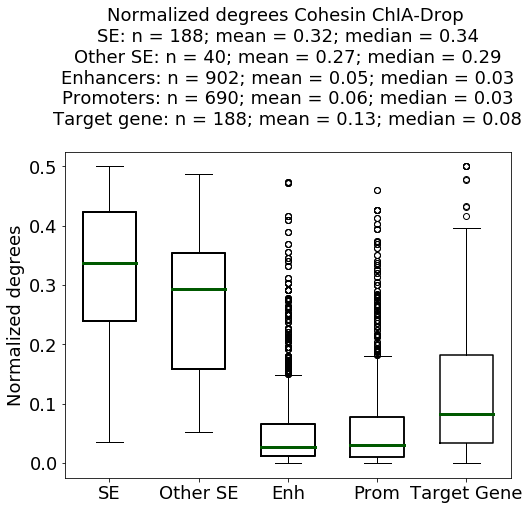

In [60]:
plot_boxplot([se_deg, ose_deg, enh_deg, prom_deg, tg_deg], ["SE", "Other SE", "Enh", "Prom", "Target Gene"], "#005900", tit, "Normalized degrees", "GM12878_Cohesin_SE_degree_centrality_normby-nEdges_boxplot_20200901")